In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!unzip /content/drive/MyDrive/cropped_images_train-20250610T093839Z-1-001.zip -d cropped_images_train1

Streaming output truncated to the last 5000 lines.
  inflating: cropped_images_train1/cropped_images_train/bike/camera4_M_127_png.rf.930b4ecb7112d1611e5ce387236d1ed7_527_431.jpg  
  inflating: cropped_images_train1/cropped_images_train/bike/camera1_A_259_png.rf.82b7dd25ee28a39aea2284cd04fba895_495_147.jpg  
  inflating: cropped_images_train1/cropped_images_train/bike/camera1_A_336_png.rf.28878db9d7ffa160f6521658ae5ddd38_327_82.jpg  
  inflating: cropped_images_train1/cropped_images_train/bike/camera4_M_127_png.rf.930b4ecb7112d1611e5ce387236d1ed7_497_173.jpg  
  inflating: cropped_images_train1/cropped_images_train/bike/camera1_A_336_png.rf.28878db9d7ffa160f6521658ae5ddd38_432_120.jpg  
  inflating: cropped_images_train1/cropped_images_train/bike/camera4_M_127_png.rf.930b4ecb7112d1611e5ce387236d1ed7_296_120.jpg  
  inflating: cropped_images_train1/cropped_images_train/bike/camera4_E_130_png.rf.e2c22a504e9db0af3a5d896d19084233_58_183.jpg  
  inflating: cropped_images_train1/cropped_image

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder('/content/cropped_images_train1/cropped_images_train', transform=transform)

# Optional: Chia train/val
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Xem tên class
print(dataset.classes)


['bike', 'bus', 'car', 'person', 'truck']


In [ ]:
# Kiểm tra thông tin của tập dữ liệu
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 45435
Number of validation samples: 11359


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Rebuild model SẠCH từ đầu
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 20)

# Gán vào GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Tạo mới optimizer sau khi model đã xong
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(20):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.long().to(device)  # đảm bảo kiểu Long

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


Epoch 1, Loss: 401.4770
Epoch 2, Loss: 211.3103
Epoch 3, Loss: 164.7550
Epoch 4, Loss: 131.2359
Epoch 5, Loss: 114.9441
Epoch 6, Loss: 95.3487
Epoch 7, Loss: 82.0200
Epoch 8, Loss: 70.4027
Epoch 9, Loss: 62.2444
Epoch 10, Loss: 54.8140
Epoch 11, Loss: 53.9853
Epoch 12, Loss: 50.0309
Epoch 13, Loss: 41.9687
Epoch 14, Loss: 38.9951
Epoch 15, Loss: 38.2307
Epoch 16, Loss: 35.8764
Epoch 17, Loss: 31.0918
Epoch 18, Loss: 31.6632
Epoch 19, Loss: 29.2760
Epoch 20, Loss: 30.3565


In [ ]:
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"✅ Accuracy: {correct / total:.2%}")


✅ Accuracy: 97.63%


In [ ]:
torch.save(model.state_dict(), "/content/efficientnetB0_epoch20.pt")

In [ ]:
!cp -r /content/efficientnetB0_epoch20.pt /content/drive/MyDrive/

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torch

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        # Chuyển dữ liệu và labels sang GPU hoặc CPU tùy thuộc vào thiết bị
        inputs, labels = inputs.to(device), labels.to(device)

        # Dự đoán
        outputs = model(inputs)

        # Lấy chỉ số lớp có xác suất cao nhất
        _, predicted = torch.max(outputs, 1)

        # Chuyển dữ liệu về CPU và chuyển thành numpy array
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tính toán các chỉ số precision, recall, và F1-Score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# In kết quả
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Precision: 0.9765859117546324
Recall: 0.9763183378818558
F1-Score: 0.9763657301545751


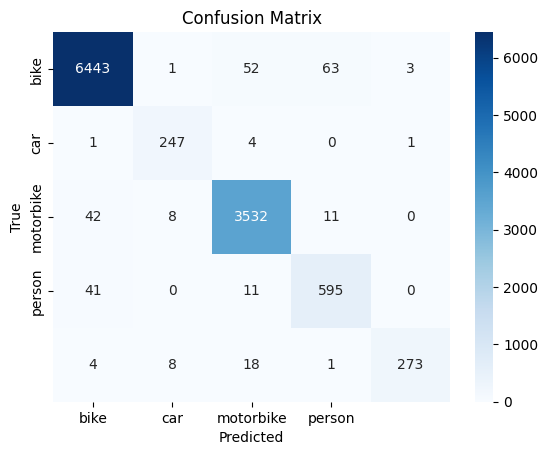

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Định nghĩa tên các lớp (class)
class_names = ['bike', 'car', 'motorbike', 'person']  # Thay đổi theo dataset của bạn

# Tính confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Vẽ heatmap cho confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Cài đặt nhãn trục và tiêu đề
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Hiển thị đồ thị
plt.show()


In [ ]:
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, labels)
print(f"Loss: {loss.item()}")


Loss: 0.856143057346344
